<a href="https://colab.research.google.com/github/SeonghwanSeo/BBAR/blob/main/experiments/generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0. Setup Environment

Working Directory: `/content/bbar`

Device: CPU (No Hardware Accelerator)

## Step 0-1. Install Packages and Change Current Directory.

In [13]:
# Install RDKit and additional packages
!pip install rdkit-pypi
!pip install omegaconf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import os
os.chdir('/content')
CODE_DIR = 'bbar'

In [15]:
!git clone https://github.com/SeonghwanSeo/BBAR.git $CODE_DIR

fatal: destination path 'bbar' already exists and is not an empty directory.


In [16]:
os.chdir(f'./{CODE_DIR}')
if not os.path.exists('./builtin_model') :
  os.mkdir('./builtin_model')

## Step 0-2. Import Packages

In [17]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors
from omegaconf import OmegaConf
from IPython.display import display, Image
import time

from src.generator import MoleculeBuilder

## Step 0-3. Util Functions

In [18]:
def display_molecule(mol, size=(300, 300)) :
    display(Chem.Draw.MolToImage(mol, size=size))

# Step 1. Generate a Single Molecule

## Step 1-1. Select Experiment Type

Select the property of interest.

Available property list
- mw (Molecular Weight)
- logp (simple log water-octanol partition coefficient)
- tpsa (topological polar surface area)
- qed (Quantitative Es- timation of Drug-likeness)

In [19]:
# Config
property_name = input('Property: ')   # Among 'mw', 'logp', 'tpsa', 'qed'
assert property_name in ['mw', 'logp', 'tpsa', 'qed']

# Get property function
# property_value = property_fn(mol)
# ex) >> Chem.Descriptors.ExactMolWt(benzene)
#     78
if property_name == 'mw' :
    property_fn = Chem.Descriptors.ExactMolWt
elif property_name == 'logp': 
    property_fn = Chem.Descriptors.MolLogP
elif property_name == 'tpsa': 
    property_fn = Chem.Descriptors.TPSA
elif property_name == 'qed': 
    property_fn = Chem.Descriptors.qed

Property: mw


## Step 1-2. Setup Generator

The first run for each property takes about a minute.

After that, it takes about 5 seconds.

In [20]:
generator_config_path = f'./experiments/generation_configs/{property_name}.yaml'
generator_config = OmegaConf.load(generator_config_path)
generator = MoleculeBuilder(generator_config)

Setup Library Building Blocks' Graph Vectors
Finish
Create Local File (./builtin_model/zinc_mw.tar)


In [25]:
print(OmegaConf.to_yaml(generator_config))

model_path: ./pretrained_model/ZINC/mw/checkpoint/best.tar
library_path: ./data/ZINC/library.csv
library_builtin_model_path: ./builtin_model/zinc_mw.tar
n_library_sample: 2000
alpha: 0.75
max_iteration: 10
idx_masking: true
compose_force: false



In [26]:
# Check Model Size (non-embeded model vs embeded model)
print('Model Parameter File')
!du -sh {generator_config.model_path}
print()
print('Library-Embedded Model Parameter File')
!du -sh {generator_config.library_builtin_model_path}

Model Parameter File
1.8M	./pretrained_model/ZINC/mw/checkpoint/best.tar

Library-Embedded Model Parameter File
25M	./builtin_model/zinc_mw.tar


## Step 1-3. Set Scaffold (Core Molecule)

Example SMILES
- `'c1ccccc1'` (benzene)
- `'CC1C(=O)CCCC1'` (2-methyl cyclohexanone)
- `'[nH]1cccc1'` (Pyrrole)
- `'c1ccc2[nH]ccc2c1'` (Indole)

SMILES: c1ccccc1


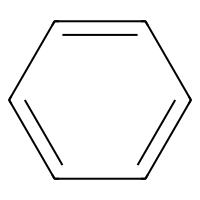

In [27]:
#scaffold_smiles = 'c1ccccc1'
scaffold_smiles = input('SMILES: ')
scaffold_mol = Chem.MolFromSmiles(scaffold_smiles)
display_molecule(scaffold_mol, size=(200, 200))

## Step 1-4. Set Target Condition

Example Condition

- **MolWt**: 200, 250, 300, 350, 400, 450, 500, 550

- **logP**: -4, -2, 0, 2, 4, 6, 8

- **TPSA**: 40, 60, 80, 100, 120, 140, 160, 180

- **QED**: 0.2, 0.4, 0.6, 0.8, 1.0

In [28]:
target_condition = float(input(f'Target {property_name}: '))

Target mw: 300


## Step 1-5. Generate a Single Molecule

Input
- Core Molecule SMILES: 'c1ccccc1'
- Condition: {'mw': 300.0}

>>> generator.generate('c1ccccc1', {'mw': 300.0})
Generation Success
O=C1CC([C@H]2CCCCO2)C(=O)N1c1ccc(CCO)cc1
mw: 303.147	(Target: 300.0)


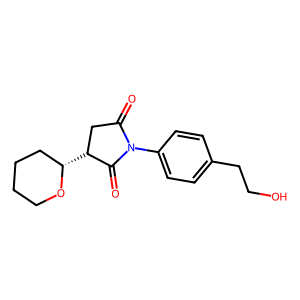

In [29]:
condition = {property_name: target_condition}
print('Input')
print(f"- Core Molecule SMILES: '{scaffold_smiles}'")
print(f'- Condition: {condition}')
print()
print(f">>> generator.generate('{scaffold_smiles}', {condition})")
generated_mol = generator.generate(scaffold_smiles, condition)
if generated_mol is None :
    print('Generation Failed')
else :
    print('Generation Success')
    generated_smiles = Chem.MolToSmiles(generated_mol)
    print(generated_smiles)
    if property_fn is not None :
        property_value = property_fn(generated_mol)
        print(f'{property_name}: {property_value:.3f}\t(Target: {target_condition})')
    display_molecule(generated_mol)

## Step 1-6. Summary

Load ./builtin_model/zinc_mw.tar


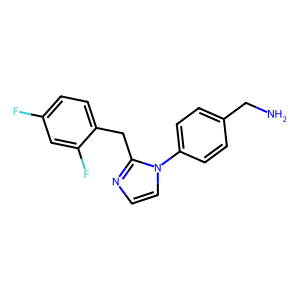

In [33]:
# Load Model
generator_config_path = './experiments/generation_configs/mw.yaml'
generator_config = OmegaConf.load(generator_config_path)
generator = MoleculeBuilder(generator_config)

# Input
scaffold_smiles = 'c1ccccc1'
condition = {'mw': 300}

# Generation
mol = generator.generate(scaffold_smiles, condition)

# Display
display_molecule(mol)

#Step 2. Generate Molecules (Statistical Analysis)

## Step 2-1. Generation Setting
Run one of the among cells.

### MolWt

Target Condition List

>  200, 250, 300, 350, 400, 450, 500, 550


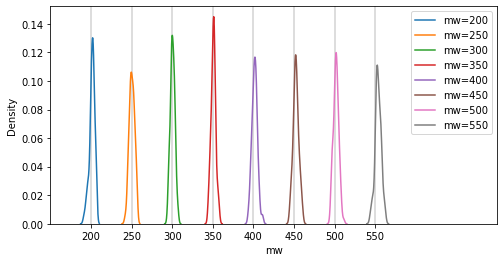

In [ ]:
Image('./experiments/images/mw.png')

In [ ]:
# Generation Setting (MW)
scaffold_smiles = 'c1ccccc1'
property_name = 'mw'
property_fn = Chem.Descriptors.ExactMolWt
num_samples = 100
target_condition_list = [200, 250, 300, 350, 400, 450, 500, 550]

# Graph Setup
property_xlim = [150, 700]

### TPSA

Target Condition List

>  40, 60, 80, 100, 120, 140, 160, 180




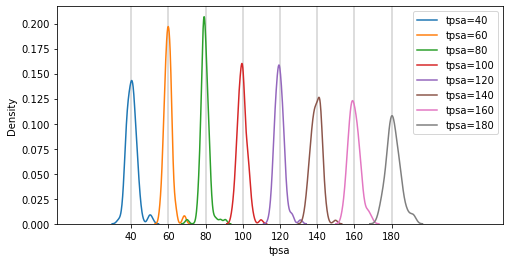

In [ ]:
Image('./experiments/images/tpsa.png')

In [34]:
# Generation Setting (TPSA)
scaffold_smiles = 'c1ccccc1'
property_name = 'tpsa'
property_fn = Chem.Descriptors.TPSA
num_samples = 100
target_condition_list = [40, 60, 80, 100, 120, 140, 160, 180]

# Graph Setup
property_xlim = [0, 240]

### logP

Target Condition List

>  -4.0, -2.0, -0.0, 2.0, 4.0, 6.0, 8.0

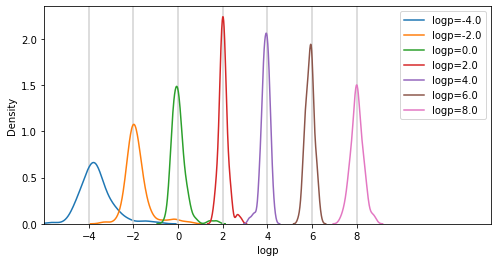

In [ ]:
Image('./experiments/images/logp.png')

In [ ]:
# Generation Setting (MW)
scaffold_smiles = 'c1ccccc1'
property_name = 'logp'
property_fn = Chem.Descriptors.MolLogP
num_samples = 100
target_condition_list = [-4.0, -2.0, 0.0, 2.0, 4.0, 6.0, 8.0]

# Graph Setup
property_xlim = [-6, 14]

### QED
Target Condition List

>  0.2, 0.4, 0.6, 0.8, 1.0

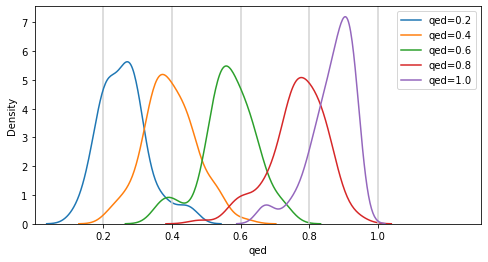

In [ ]:
Image('./experiments/images/qed.png')

In [ ]:
# Generation Setting (QED)
scaffold_smiles = 'c1ccccc1'
property_name = 'qed'
property_fn = Chem.Descriptors.qed
num_samples = 100
target_condition_list = [0.2, 0.4, 0.6, 0.8, 1.0]

# Graph Setup
property_xlim = [0, 1.3]

## Step 2-2. Generation

In [35]:
# Setup Generator
generator_config_path = f'./experiments/generation_configs/{property_name}.yaml'
generator_config = OmegaConf.load(generator_config_path)
generator = MoleculeBuilder(generator_config)

# Run Generator
print('\nGeneration Start!')
print(f'Core Molecule: {scaffold_smiles}')
generation_dict = {condition: [] for condition in target_condition_list}
for target_condition in target_condition_list :
    mol_list = generation_dict[target_condition]
    condition = {property_name: target_condition}
    print(f'{property_name}: {target_condition}', end='\t')

    st = time.time()
    for _ in range(num_samples) :
        mol = generator.generate(scaffold_smiles, condition)
        if mol is not None :
            mol_list.append(mol)
    end = time.time()
    time_cost = end - st
    print(f'Success: {len(mol_list)}/{num_samples}\t{time_cost/num_samples:.3f} sec/mol')

Setup Library Building Blocks' Graph Vectors
Finish
Create Local File (./builtin_model/zinc_tpsa.tar)

Generation Start!
Core Molecule: c1ccccc1
tpsa: 40	Success: 100/100	0.053 sec/mol
tpsa: 60	Success: 100/100	0.057 sec/mol
tpsa: 80	Success: 100/100	0.062 sec/mol
tpsa: 100	Success: 100/100	0.064 sec/mol
tpsa: 120	Success: 100/100	0.067 sec/mol
tpsa: 140	Success: 100/100	0.070 sec/mol
tpsa: 160	Success: 100/100	0.068 sec/mol
tpsa: 180	Success: 100/100	0.073 sec/mol


## Step 2-3. Draw Distribution Graph

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

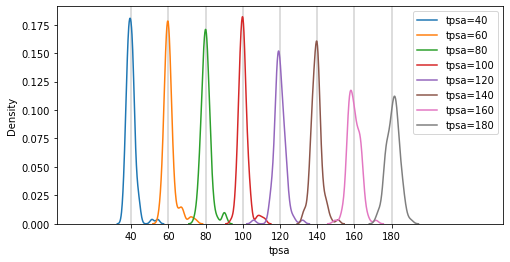

In [37]:
plt.figure(figsize=(8,4))
for target_condition in target_condition_list :
    generated_mol_list = generation_dict[target_condition]
    property_value_list = [property_fn(mol) for mol in generated_mol_list]
    plt.axvline(target_condition, color='lightgrey')
    sns.kdeplot(property_value_list, label=f'{property_name}={target_condition}')
plt.xlim(property_xlim)
plt.xlabel(property_name)
plt.xticks(target_condition_list)
plt.legend()
plt.show()

# Step 3. Design inhibitors against 3CL Protease of SARS-Cov-2



**Reference Ligand**

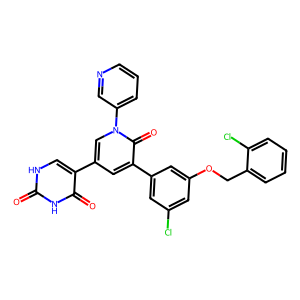

In [ ]:
Image('./experiments/images/reference_ligand.png')

Load ./builtin_model/3cl_docking.tar

Generation Start!
Core Molecule: c1ccccc1
affinity: -10	Cc1ccc(C)c(N2C(=O)C([O-])=C(C(=O)c3ccc(SCc4cccs4)cc3)C2c2ccc(O)cc2)c1


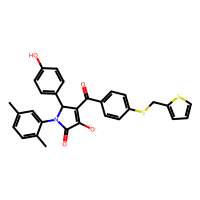

O=c1cc(-c2ccc3c(c2)CCO3)nc(N2CCN(Cc3nc(Cl)cc(-c4ccccc4)n3)CC2)[nH]1


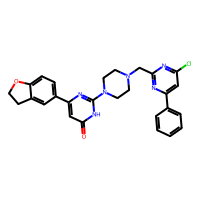

Cn1cnc2cc(-c3nc(-c4ccc(-c5ccccc5)c(=O)[nH]4)nn3-c3ccc4ccccc4n3)ccc21


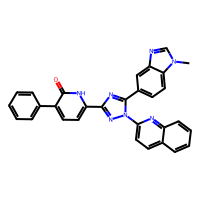

Cc1cccc(C[C@@H](C(=O)c2cnc(Cc3ccc4c(c3)OCO4)c(-c3cccc(C)n3)n2)c2ccccc2)c1


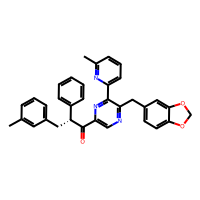

CC(C)c1ccc(-c2ccc([N-]C(=O)Nc3ccc(S(=O)(=O)N4CCC[C@@H](C)C4)cc3)nn2)cc1


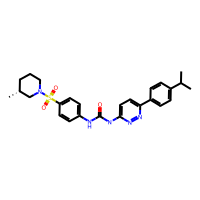

In [39]:
# Generation Setting (3CL)
scaffold_smiles = 'c1ccccc1'
property_name = 'affinity'
target_condition = -10

# Setup Generator
generator_config_path = f'./experiments/generation_configs/3cl_affinity.yaml'
generator_config = OmegaConf.load(generator_config_path)
generator = MoleculeBuilder(generator_config)

# Run Generator
print('\nGeneration Start!')
print(f'Core Molecule: {scaffold_smiles}')

generator.setup({property_name: target_condition})
print(f'{property_name}: {target_condition}', end='\t')

for _ in range(5) :
    mol = generator.generate(scaffold_smiles)
    if mol is not None :
        print(Chem.MolToSmiles(mol))
        display_molecule(mol, size=(200, 200))